In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import csv
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile

In [17]:
wavfile

<module 'scipy.io.wavfile' from '/usr/local/lib/python3.10/dist-packages/scipy/io/wavfile.py'>

<h1>Load the Model</h1>

In [5]:
model=hub.load("https://tfhub.dev/google/yamnet/1")
print(model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7928d0f13af0>


In [7]:
def class_names_from_csv(class_map_csv_text):
    class_names=[]
    with tf.io.gfile.GFile(class_map_csv_text)as csvfile:
        reader=csv.DictReader(csvfile)
        for row in reader:
            class_names.append(row['display_name'])
        return class_names
class_map_path=model.class_map_path().numpy()
class_names=class_names_from_csv(class_map_path)

In [9]:
def ensure_sample_rate(original_sample_rate,waveform,desired_sample_rate=16000):
    if original_sample_rate !=desired_sample_rate:
        desired_length=int(round(float(len(waveform))/
                          original_sample_rate*desired_sample_rate))
        waveform=scipy.signal.resample(waveform,desired_length)
    return desired_sample_rate,waveform
        

In [12]:
!curl -O https://storage.googleapis.com/audioset/speech_whistling2.wav

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  153k  100  153k    0     0   884k      0 --:--:-- --:--:-- --:--:--  888k


In [13]:
!curl -O https://storage.googleapis.com/audioset/miaow_16k.wav

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  210k  100  210k    0     0  1387k      0 --:--:-- --:--:-- --:--:-- 1384k


In [31]:
wav_file='/kaggle/working/miaow_16k.wav'
sample_rate,wav_data=wavfile.read(wav_file,'rb')
sample_rate,wav_data=ensure_sample_rate(sample_rate,wav_data)

duration=len(wav_data)/sample_rate
print(f"Sample rate:{sample_rate} hz")
print(f"Total duration :{duration:.2f}s")
print(f"Size of the input:{len(wav_data)}")

Audio(wav_data,rate=sample_rate)

Sample rate:16000 hz
Total duration :6.73s
Size of the input:107698


<ipython-input-31-75d0dd73d101>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate,wav_data=wavfile.read(wav_file,'rb')


In [32]:
waveform=wav_data/tf.int16.max

In [33]:
scores,embeddings,spectrogram=model(waveform)

In [34]:
scores_np=scores.numpy()
spectrogram_np=spectrogram.numpy()
infered_class=class_names[scores_np.mean(axis=0).argmax()]
print(f"the main sound is :{infered_class}")

the main sound is :Animal


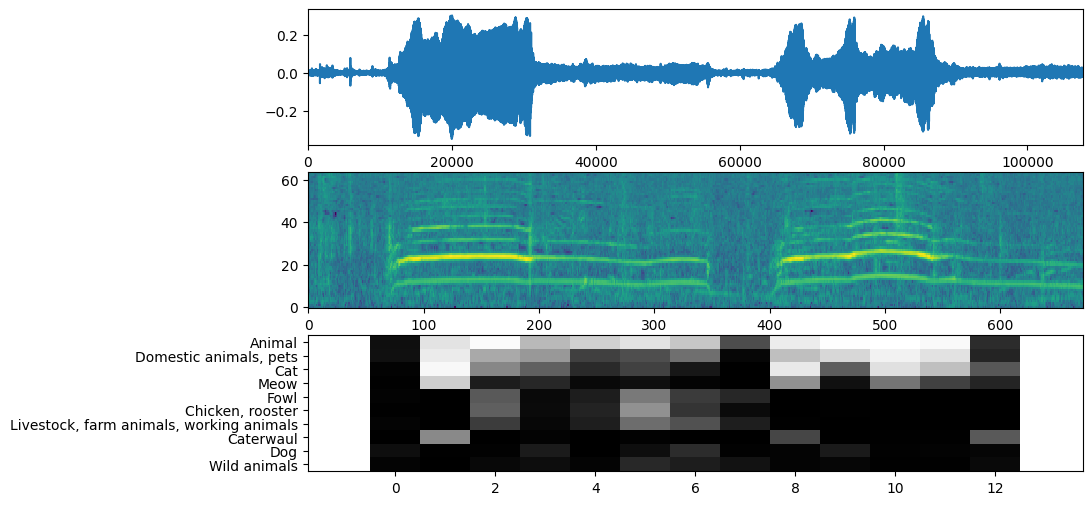

In [35]:
plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.plot(waveform)
plt.xlim([0,len(waveform)])
plt.subplot(3,1,2)
plt.imshow(spectrogram_np.T,aspect='auto',interpolation='nearest',origin='lower')
mean_scores=np.mean(scores,axis=0)
top_n=10
top_class_indices=np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3,1,3)
plt.imshow(scores_np[:,top_class_indices].T,aspect='auto',interpolation='nearest',cmap='gray')
patch_padding=(0.025/2)/0.01
plt.xlim([-patch_padding-0.5,scores.shape[0]+patch_padding-0.5])
yticks=range(0,top_n,1)
plt.yticks(yticks,[class_names[top_class_indices[x]] for x in yticks])
_ =plt.ylim(-0.5+np.array([top_n,0]))